In [1]:
import math
import joblib

import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [2]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
df = pd.read_parquet('../data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [4]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799886667

/Users/syhamdani/.pyenv/versions/3.9.12/envs/mlops/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/syhamdani/.pyenv/versions/3.9.12/envs/mlops/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


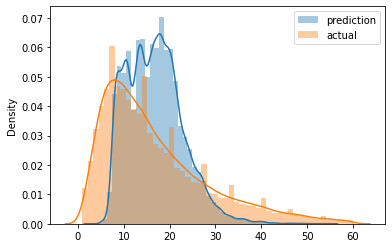

In [5]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [6]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')

In [8]:
len(df_train), len(df_val)

(73908, 61921)

In [9]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [10]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715199477344

In [13]:
joblib.dump((dv, lr), 'models/lin_reg.joblib')

['models/lin_reg.joblib']

In [14]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728

In [17]:
with mlflow.start_run():
    mlflow.set_tag("scientist", "syahrulhamdani")
    mlflow.log_params({
        "train-data-path": "../data/green_tripdata_2021-01.parquet",
        "dev-data-path": "../data/green_tripdata_2021-02.parquet"
    })

    alpha = .1
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(0.01)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [19]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [47]:
def objective_func(params: dict):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=1000,
            evals=[(dval, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(dval)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {
        "loss": rmse,
        "status": STATUS_OK
    }

In [48]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": "reg:linear",
    "seed": 42
}

In [ ]:
best_result = fmin(
    fn=objective_func,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[15:58:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:20.23863                                                                                                                                                                                
[1]	validation-rmse:19.34084                                                                                                                                                                                
[2]	validation-rmse:18.49475                                                                                                                                                                                
[3]	validation-rmse:17.69990                                                                                                                                                     

In [53]:
params = {
    "learning_rate": 0.13568542351901228,
    "max_depth": 24,
    "min_child_weight": 1.426739788197608,
    "objective": "reg:linear",
    "reg_alpha": 0.0523149429147391,
    "reg_lambda": 0.1385524435325633,
    "seed": 42,
}

mlflow.xgboost.autolog()
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dval, "validation")],
    early_stopping_rounds=50
)

2022/05/29 17:20:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6752e8b23d0d47a28f5dbe60e0b205e0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[17:20:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.77812
[1]	validation-rmse:16.72669
[2]	validation-rmse:14.98726
[3]	validation-rmse:13.52144
[4]	validation-rmse:12.29151
[5]	validation-rmse:11.26415
[6]	validation-rmse:10.41001
[7]	validation-rmse:9.70522
[8]	validation-rmse:9.12481
[9]	validation-rmse:8.65103
[10]	validation-rmse:8.26363
[11]	validation-rmse:7.94859
[12]	validation-rmse:7.69326
[13]	validation-rmse:7.48613
[14]	validation-rmse:7.31771
[15]	validation-rmse:7.18132
[16]	validation-rmse:7.06954
[17]	validation-rmse:6.97811
[18]	validation-rmse:6.90295
[19]	validation-rmse:6.84022
[20]	validation-rmse:6.78910
[21]	validation-rmse:6.74548
[22]	validation-rmse:6.70944
[23]	validation-rmse:6.67814
[24]	validation-rmse:6.65325
[25]	validation-rmse:6.63187
[26]	validation-rmse:6.61402
[27]	validat

2022/05/29 17:22:13 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


In [55]:
params = {
    "learning_rate": 0.13568542351901228,
    "max_depth": 24,
    "min_child_weight": 1.426739788197608,
    "objective": "reg:linear",
    "reg_alpha": 0.0523149429147391,
    "reg_lambda": 0.1385524435325633,
    "seed": 42,
}

with mlflow.start_run():
    mlflow.set_tag("scientist", "syahrulhamdani")
    mlflow.log_params({
        "train-data-path": "../data/green_tripdata_2021-01.parquet",
        "dev-data-path": "../data/green_tripdata_2021-02.parquet"
    })

    alpha = .1
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(0.01)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_artifact(local_path="models/lin_reg.joblib", artifact_path="models_joblib")

In [23]:
with mlflow.start_run():
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        "learning_rate": 0.13568542351901228,
        "max_depth": 24,
        "min_child_weight": 1.426739788197608,
        "objective": "reg:linear",
        "reg_alpha": 0.0523149429147391,
        "reg_lambda": 0.1385524435325633,
        "seed": 42,
    }
    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dval, "validation")],
        early_stopping_rounds=50
    )
    y_pred = booster.predict(dval)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    joblib.dump(dv, "models/vectorizer.joblib")
    mlflow.log_artifact("models/vectorizer.joblib", artifact_path="vectorizer_mlflow")

    mlflow.log_metric("rmse", rmse)
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[23:16:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.77812
[1]	validation-rmse:16.72669
[2]	validation-rmse:14.98726
[3]	validation-rmse:13.52144
[4]	validation-rmse:12.29151
[5]	validation-rmse:11.26415
[6]	validation-rmse:10.41001
[7]	validation-rmse:9.70522
[8]	validation-rmse:9.12481
[9]	validation-rmse:8.65103
[10]	validation-rmse:8.26363
[11]	validation-rmse:7.94859
[12]	validation-rmse:7.69326
[13]	validation-rmse:7.48613
[14]	validation-rmse:7.31771
[15]	validation-rmse:7.18132
[16]	validation-rmse:7.06954
[17]	validation-rmse:6.97811
[18]	validation-rmse:6.90295
[19]	validation-rmse:6.84022
[20]	validation-rmse:6.78910
[21]	validation-rmse:6.74548
[22]	validation-rmse:6.70944
[23]	validation-rmse:6.67814
[24]	validation-rmse:6.65325
[25]	validation-rmse:6.63187
[26]	validation-rmse:6.61402
[27]	validat

In [24]:
with mlflow.start_run():
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = {
        "learning_rate": 0.2716228733876462,
        "max_depth": 24,
        "min_child_weight": 1.4757548201474235,
        "objective": "reg:linear",
        "reg_alpha": 0.14954205425845127,
        "reg_lambda": 0.04365535826465089,
        "seed": 42,
    }
    mlflow.log_params(params)

    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dval, "validation")],
        early_stopping_rounds=50
    )
    y_pred = booster.predict(dval)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    joblib.dump(dv, "models/vectorizer.joblib")
    mlflow.log_artifact("models/vectorizer.joblib", artifact_path="vectorizer_mlflow")

    mlflow.log_metric("rmse", rmse)
    mlflow.xgboost.log_model(booster, artifact_path="models")

[23:35:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:16.40782
[1]	validation-rmse:13.07964
[2]	validation-rmse:10.80783
[3]	validation-rmse:9.29697
[4]	validation-rmse:8.32051
[5]	validation-rmse:7.69389
[6]	validation-rmse:7.29348
[7]	validation-rmse:7.03771
[8]	validation-rmse:6.87155
[9]	validation-rmse:6.76351
[10]	validation-rmse:6.68937
[11]	validation-rmse:6.63621
[12]	validation-rmse:6.60124
[13]	validation-rmse:6.57454
[14]	validation-rmse:6.55623
[15]	validation-rmse:6.54360
[16]	validation-rmse:6.53622
[17]	validation-rmse:6.53062
[18]	validation-rmse:6.52379
[19]	validation-rmse:6.51987
[20]	validation-rmse:6.51606
[21]	validation-rmse:6.51212
[22]	validation-rmse:6.50989
[23]	validation-rmse:6.50579
[24]	validation-rmse:6.50216
[25]	validation-rmse:6.49977
[26]	validation-rmse:6.49742
[27]	validation-